In [2]:
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=47)

In [3]:
print(f"First 5 X features: \n{X[:5]}")
print(f"\nFirst 5 y labels: \n{y[:5]}")

First 5 X features: 
[[ 0.75010044  0.32927743]
 [ 0.42155587 -0.63126662]
 [ 0.38718041  0.67567739]
 [ 0.96857531  0.29659105]
 [-0.5293135  -0.82036775]]

First 5 y labels: 
[1 1 1 0 0]


In [4]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], "X2":X[:,1], "label": y})
circles.head(10)

,X1,X2,label
0,0.750100,0.329277,1
1,0.421556,-0.631267,1
2,0.387180,0.675677,1
3,0.968575,0.296591,0
4,-0.529314,-0.820368,0
5,-0.585169,0.619087,1
6,0.499984,0.618339,1
7,0.236580,-0.813342,1
8,0.545943,-0.538150,1
9,0.094928,1.013539,0


In [5]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

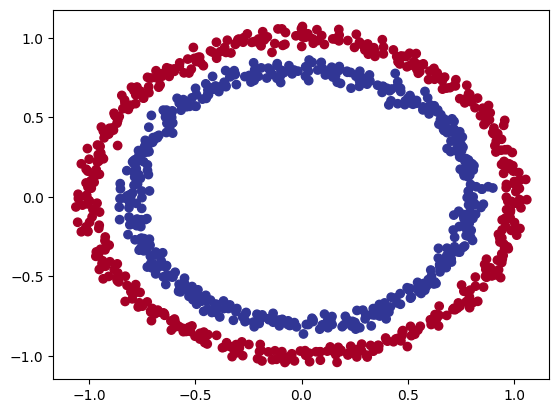

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [7]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7501,  0.3293],
         [ 0.4216, -0.6313],
         [ 0.3872,  0.6757],
         [ 0.9686,  0.2966],
         [-0.5293, -0.8204]]),
 tensor([1., 1., 1., 0., 0.]))

In [8]:
# split data for training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [9]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [10]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [12]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
torch.manual_seed(47)
epoches = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epoches):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test ACC: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70184, Accuracy: 50.25% | Test Loss: 0.70812, Test ACC: 49.00%
Epoch: 10 | Loss: 0.69683, Accuracy: 50.25% | Test Loss: 0.70208, Test ACC: 49.00%
Epoch: 20 | Loss: 0.69481, Accuracy: 60.38% | Test Loss: 0.69946, Test ACC: 52.50%
Epoch: 30 | Loss: 0.69393, Accuracy: 54.00% | Test Loss: 0.69826, Test ACC: 50.00%
Epoch: 40 | Loss: 0.69352, Accuracy: 52.25% | Test Loss: 0.69770, Test ACC: 50.00%
Epoch: 50 | Loss: 0.69332, Accuracy: 51.88% | Test Loss: 0.69744, Test ACC: 50.00%
Epoch: 60 | Loss: 0.69320, Accuracy: 51.50% | Test Loss: 0.69731, Test ACC: 50.50%
Epoch: 70 | Loss: 0.69314, Accuracy: 51.62% | Test Loss: 0.69725, Test ACC: 50.50%
Epoch: 80 | Loss: 0.69309, Accuracy: 51.62% | Test Loss: 0.69722, Test ACC: 50.50%
Epoch: 90 | Loss: 0.69306, Accuracy: 51.50% | Test Loss: 0.69720, Test ACC: 50.00%
Epoch: 100 | Loss: 0.69304, Accuracy: 51.38% | Test Loss: 0.69719, Test ACC: 48.00%
Epoch: 110 | Loss: 0.69302, Accuracy: 51.25% | Test Loss: 0.69717, Test ACC: 47.50%
Epo

In [14]:
from utils.helper_functions import plot_predictions, plot_decision_boundary

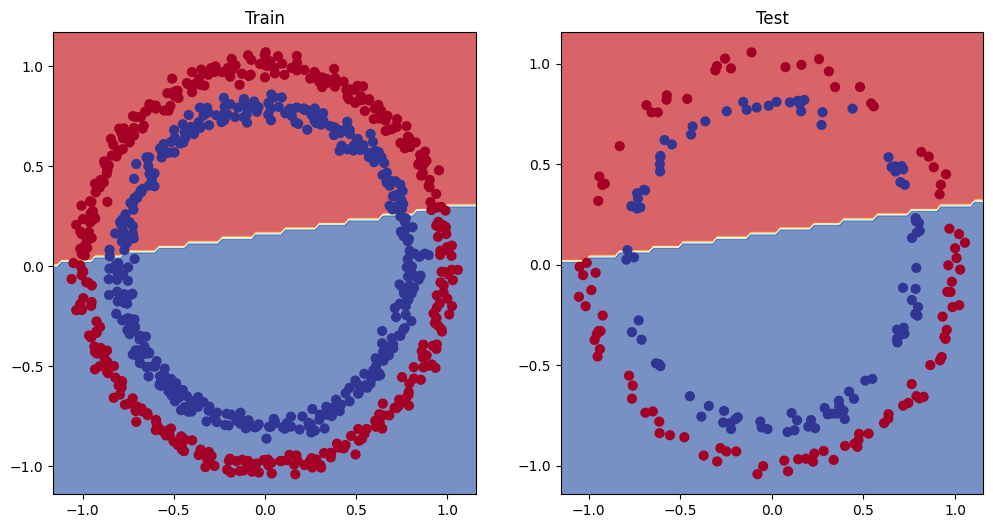

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [16]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [18]:
torch.manual_seed(47)
epoches = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epoches):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test ACC: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69434, Accuracy: 59.38% | Test Loss: 0.69835, Test ACC: 53.00%
Epoch: 10 | Loss: 0.69346, Accuracy: 53.37% | Test Loss: 0.69725, Test ACC: 51.00%
Epoch: 20 | Loss: 0.69317, Accuracy: 51.50% | Test Loss: 0.69677, Test ACC: 50.00%
Epoch: 30 | Loss: 0.69305, Accuracy: 51.88% | Test Loss: 0.69650, Test ACC: 48.50%
Epoch: 40 | Loss: 0.69299, Accuracy: 51.25% | Test Loss: 0.69633, Test ACC: 48.00%
Epoch: 50 | Loss: 0.69295, Accuracy: 51.12% | Test Loss: 0.69620, Test ACC: 47.50%
Epoch: 60 | Loss: 0.69293, Accuracy: 51.50% | Test Loss: 0.69611, Test ACC: 47.50%
Epoch: 70 | Loss: 0.69291, Accuracy: 51.75% | Test Loss: 0.69603, Test ACC: 46.50%
Epoch: 80 | Loss: 0.69290, Accuracy: 52.00% | Test Loss: 0.69597, Test ACC: 46.00%
Epoch: 90 | Loss: 0.69289, Accuracy: 51.88% | Test Loss: 0.69593, Test ACC: 46.00%
Epoch: 100 | Loss: 0.69288, Accuracy: 51.88% | Test Loss: 0.69589, Test ACC: 44.00%
Epoch: 110 | Loss: 0.69287, Accuracy: 52.00% | Test Loss: 0.69586, Test ACC: 44.00%
Epo

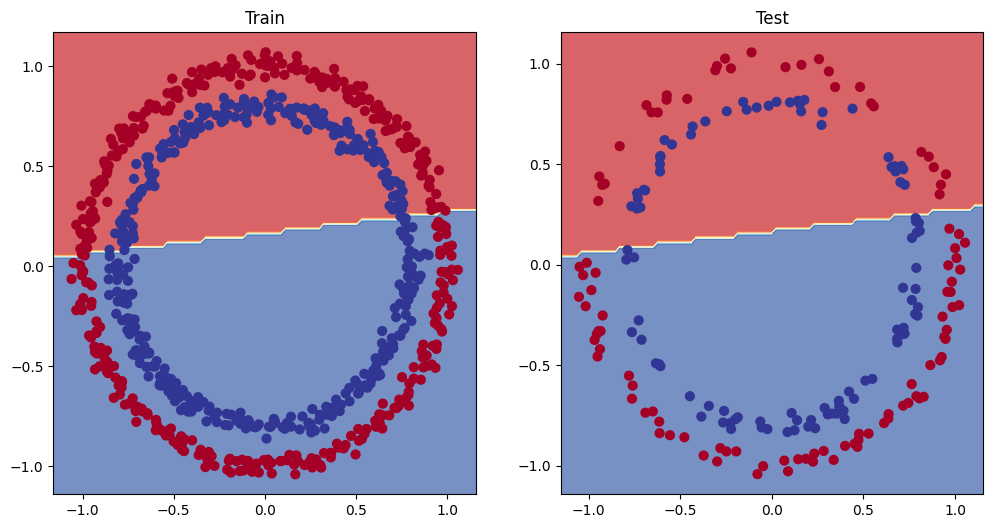

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [20]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [22]:
torch.manual_seed(47)
epoches = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epoches):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test ACC: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69294, Accuracy: 49.25% | Test Loss: 0.69208, Test ACC: 52.50%
Epoch: 10 | Loss: 0.69268, Accuracy: 49.25% | Test Loss: 0.69192, Test ACC: 53.50%
Epoch: 20 | Loss: 0.69245, Accuracy: 50.00% | Test Loss: 0.69176, Test ACC: 54.50%
Epoch: 30 | Loss: 0.69221, Accuracy: 50.88% | Test Loss: 0.69157, Test ACC: 55.50%
Epoch: 40 | Loss: 0.69195, Accuracy: 51.38% | Test Loss: 0.69136, Test ACC: 56.00%
Epoch: 50 | Loss: 0.69170, Accuracy: 52.62% | Test Loss: 0.69115, Test ACC: 57.50%
Epoch: 60 | Loss: 0.69146, Accuracy: 53.87% | Test Loss: 0.69095, Test ACC: 57.50%
Epoch: 70 | Loss: 0.69120, Accuracy: 56.50% | Test Loss: 0.69074, Test ACC: 58.50%
Epoch: 80 | Loss: 0.69089, Accuracy: 59.50% | Test Loss: 0.69046, Test ACC: 60.50%
Epoch: 90 | Loss: 0.68989, Accuracy: 60.62% | Test Loss: 0.68983, Test ACC: 62.00%
Epoch: 100 | Loss: 0.68912, Accuracy: 64.00% | Test Loss: 0.68939, Test ACC: 65.00%
Epoch: 110 | Loss: 0.68866, Accuracy: 67.12% | Test Loss: 0.68901, Test ACC: 67.00%
Epo

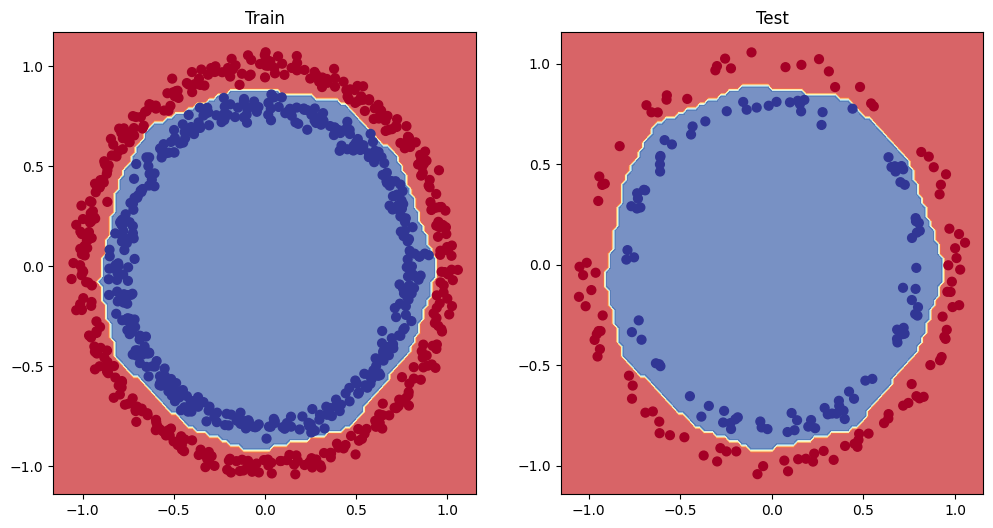

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [24]:
A = torch.arange(-10, 10, 1, dtype=torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

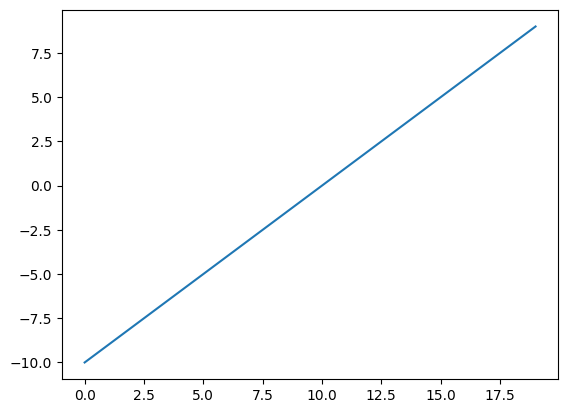

In [25]:
plt.plot(A)

In [26]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

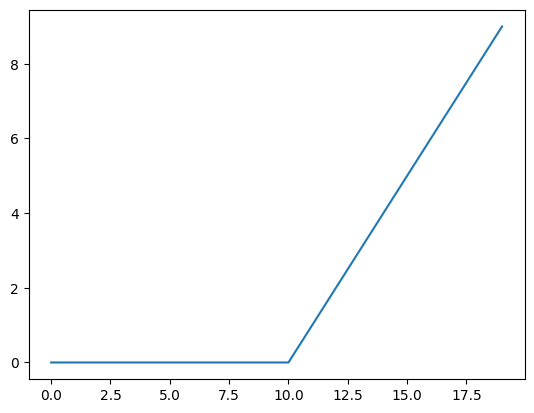

In [27]:
plt.plot(relu(A))

In [28]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

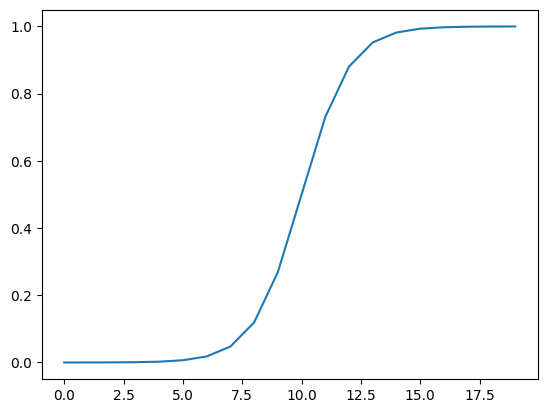

In [29]:
plt.plot(sigmoid(A))

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


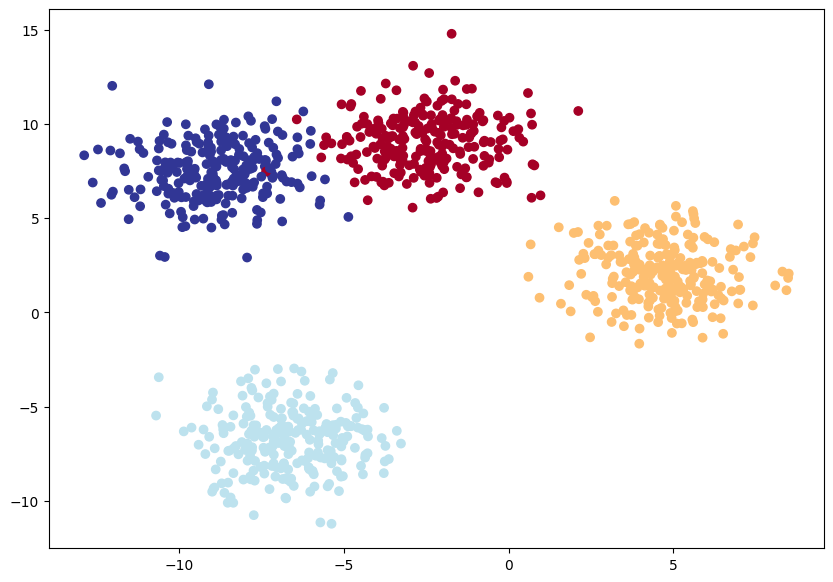

In [31]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [35]:
model_4(X_blob_train.to(device))[:5]

tensor([[-0.1778, -0.2339,  1.0653, -0.9930],
        [-0.3463,  1.1062,  0.2713, -0.3703],
        [ 0.3601, -0.7309, -1.4954,  0.6711],
        [ 0.1777, -0.3533, -0.9086,  0.3086],
        [-0.2586,  0.8764,  0.0543, -0.2427]], grad_fn=<SliceBackward0>)

In [36]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.98855, Acc: 0.00% | Test Loss: 0.62401, Test Acc: 79.50%
Epoch: 10 | Loss: 0.15025, Acc: 99.25% | Test Loss: 0.13524, Test Acc: 99.50%
Epoch: 20 | Loss: 0.08288, Acc: 99.25% | Test Loss: 0.07445, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06035, Acc: 99.12% | Test Loss: 0.05257, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04950, Acc: 99.12% | Test Loss: 0.04167, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04325, Acc: 99.12% | Test Loss: 0.03524, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03923, Acc: 99.12% | Test Loss: 0.03103, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03645, Acc: 99.12% | Test Loss: 0.02807, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03443, Acc: 99.12% | Test Loss: 0.02588, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03291, Acc: 99.12% | Test Loss: 0.02420, Test Acc: 99.50%


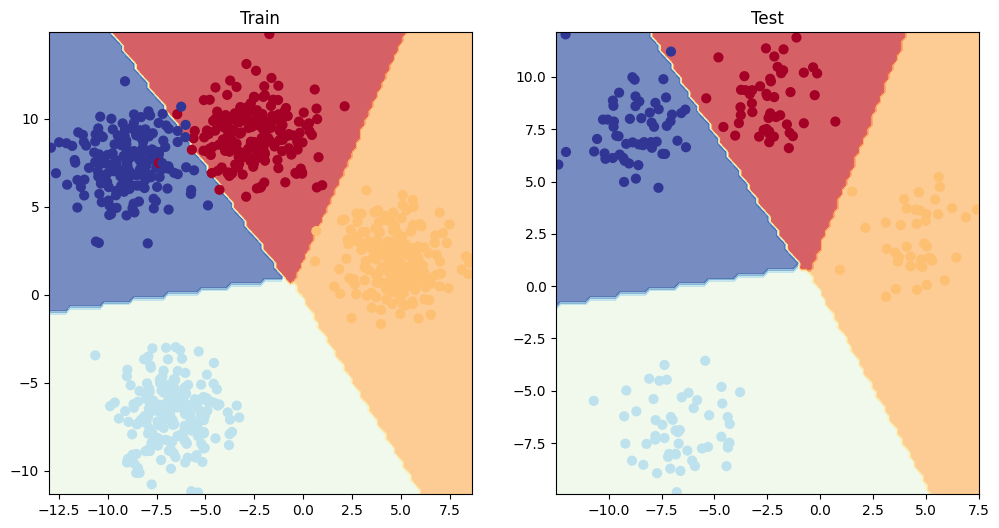

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [43]:
xx = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])

row_sums = xx.sum(dim=0)
print(row_sums)
row_sums = xx.sum(dim=1)
print(row_sums)


tensor([5, 7, 9])
tensor([ 6, 15])
